In [1]:
import pandas as pd
import os

In [2]:
# directory list
train_path = '../input/kue-indonesia/train/'
test_path = '../input/kue-indonesia/test/'
validation_path = '../input/kue-indonesia/validation/'
items = os.listdir(train_path)
items

['kue_risoles',
 'kue_lumpur',
 'kue_kastengel',
 'kue_dadar_gulung',
 'kue_putri_salju',
 'kue_klepon',
 'kue_serabi',
 'kue_lapis']

In [3]:
# create items path
train_dir = []
test_dir = []
validation_dir = []
for item in items :
    train_dir.append(train_path + item + '/')
    test_dir.append(test_path + item + '/')
    validation_dir.append(validation_path + item + '/')

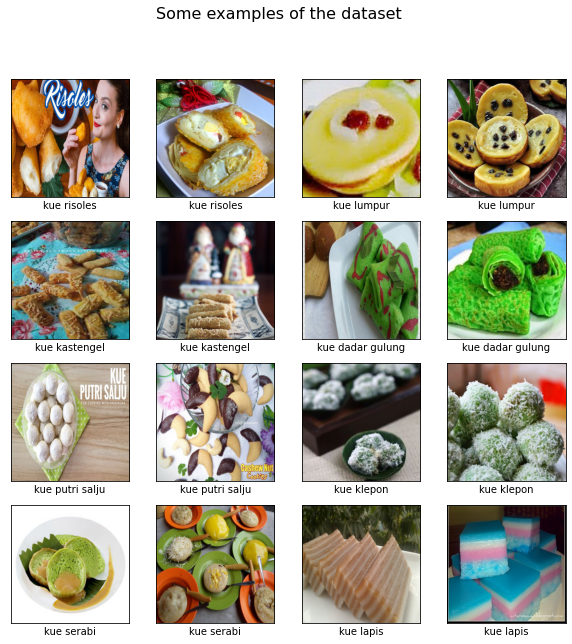

In [4]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2

labels = [(" ").join(x.split('_')) for x in items]

fig = plt.figure(figsize=(10,10))
fig.suptitle("Some examples of the dataset", fontsize=16)
i = 1
for path in train_dir :
    for j in range(2) :
        img = mpimg.imread(path+os.listdir(path)[j])
        size = min(img.shape[0], img.shape[1])
        img = cv2.resize(img, (size,size))
        
        plt.subplot(4,4,i)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(img, cmap=plt.cm.binary)
        plt.xlabel(labels[int((i-1)/2)])
        i += 1
plt.show()

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

TRAINING_DIR = train_path
train_datagen = ImageDataGenerator( rescale = 1.0/255. ,
                                  rotation_range=40,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=16,
                                                    class_mode='categorical',
                                                    target_size=(150, 150))

VALIDATION_DIR = validation_path
validation_datagen = ImageDataGenerator( rescale = 1.0/255. ,
                                  rotation_range=40,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  fill_mode='nearest')

validation_generator = train_datagen.flow_from_directory(VALIDATION_DIR,
                                                    batch_size=16,
                                                    class_mode='categorical',
                                                    target_size=(150, 150))




Found 1516 images belonging to 8 classes.
Found 160 images belonging to 8 classes.


In [6]:
TEST_DIR = test_path
test_datagen = ImageDataGenerator(rescale = 1./255)
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(150,150),
    class_mode='categorical',
    batch_size=10)

Found 160 images belonging to 8 classes.


# Define Callbacks

In [7]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger, EarlyStopping

def callbacks():
    cb = []

    reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss',  
                                       factor=0.5, patience=1, 
                                       verbose=1, mode='min', 
                                       epsilon=0.0001, min_lr=0,
                                       restore_best_weights=True)
    cb.append(reduceLROnPlat)
    
    log = CSVLogger('log.csv')
    cb.append(log)
    
    es = EarlyStopping(monitor='val_loss', patience=5, verbose=0,
                       mode='min', restore_best_weights=True)
    
    cb.append(es)
    
    return cb

# VGG16

In [8]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop

local_weights_file = '../input/vgg16-weights/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = VGG16(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = None)

pre_trained_model.load_weights(local_weights_file)

In [9]:
for layer in pre_trained_model.layers:
    layer.trainable = False


last_layer = pre_trained_model.get_layer('block5_pool')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output
# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
x = layers.Dense  (8, activation='softmax')(x)           

model = Model( pre_trained_model.input, x) 

model.compile(optimizer = 'adam', 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

last layer output shape:  (None, 4, 4, 512)


In [10]:
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            epochs = 200,
            verbose = 1,
            callbacks = callbacks())

Epoch 1/200
95/95 [==============================] - 69s 726ms/step - loss: 1.6999 - accuracy: 0.5000 - val_loss: 1.0264 - val_accuracy: 0.6562 - lr: 0.0010
Epoch 2/200
95/95 [==============================] - 68s 713ms/step - loss: 0.9865 - accuracy: 0.6524 - val_loss: 1.0000 - val_accuracy: 0.5938 - lr: 0.0010
Epoch 3/200
95/95 [==============================] - 67s 704ms/step - loss: 0.8317 - accuracy: 0.7111 - val_loss: 0.8012 - val_accuracy: 0.7188 - lr: 0.0010
Epoch 4/200
95/95 [==============================] - ETA: 0s - loss: 0.8167 - accuracy: 0.7282
Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
95/95 [==============================] - 65s 686ms/step - loss: 0.8167 - accuracy: 0.7282 - val_loss: 0.9223 - val_accuracy: 0.6500 - lr: 0.0010
Epoch 5/200
95/95 [==============================] - 65s 679ms/step - loss: 0.6937 - accuracy: 0.7487 - val_loss: 0.7874 - val_accuracy: 0.7188 - lr: 5.0000e-04
Epoch 6/200
95/95 [=============================

In [11]:
results = model.evaluate(test_generator)

16/16 [==============================] - 7s 436ms/step - loss: 0.5718 - accuracy: 0.7937


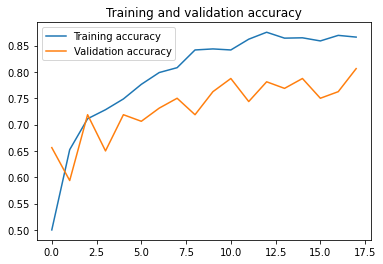

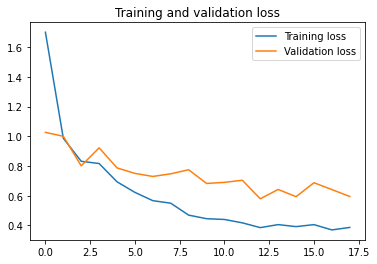

In [12]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc)) # Get number of epochs

plt.figure()
#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  ( epochs,     loss, label='Training loss' )
plt.plot  ( epochs, val_loss, label='Validation loss' )
plt.title ('Training and validation loss')
plt.legend(loc=0)

plt.show()

In [13]:
model.save_weights('model_vgg16.h5')

# InceptionV3

In [14]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = '../input/inceptionv3/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = None)

pre_trained_model.load_weights(local_weights_file)


In [15]:
for layer in pre_trained_model.layers:
  layer.trainable = False
  

last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output
# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
x = layers.Dense  (8, activation='softmax')(x)           

model_inceptionV3 = Model( pre_trained_model.input, x) 

model_inceptionV3.compile(optimizer = 'adam', 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

last layer output shape:  (None, 7, 7, 768)


In [16]:
history = model_inceptionV3.fit(
            train_generator,
            validation_data = validation_generator,
            epochs = 200,
            verbose = 1,
            callbacks = callbacks())

Epoch 1/200
95/95 [==============================] - 66s 697ms/step - loss: 1.8491 - accuracy: 0.5858 - val_loss: 0.6110 - val_accuracy: 0.7937 - lr: 0.0010
Epoch 2/200
95/95 [==============================] - 64s 676ms/step - loss: 0.6427 - accuracy: 0.7823 - val_loss: 0.5454 - val_accuracy: 0.8000 - lr: 0.0010
Epoch 3/200
95/95 [==============================] - 65s 684ms/step - loss: 0.5441 - accuracy: 0.8212 - val_loss: 0.5278 - val_accuracy: 0.8125 - lr: 0.0010
Epoch 4/200
95/95 [==============================] - ETA: 0s - loss: 0.4508 - accuracy: 0.8417
Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
95/95 [==============================] - 65s 684ms/step - loss: 0.4508 - accuracy: 0.8417 - val_loss: 0.5797 - val_accuracy: 0.7875 - lr: 0.0010
Epoch 5/200
95/95 [==============================] - 64s 678ms/step - loss: 0.3843 - accuracy: 0.8628 - val_loss: 0.4689 - val_accuracy: 0.8313 - lr: 5.0000e-04
Epoch 6/200
95/95 [=============================

In [17]:
results = model_inceptionV3.evaluate(test_generator)

16/16 [==============================] - 7s 435ms/step - loss: 0.2490 - accuracy: 0.9187


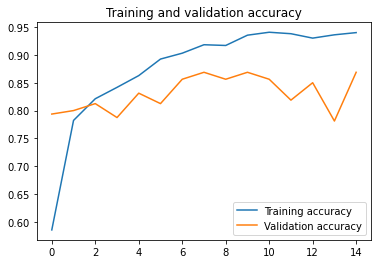

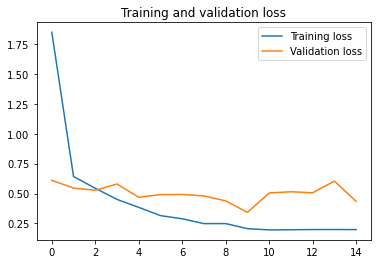

In [18]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc)) # Get number of epochs

plt.figure()
#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  ( epochs,     loss, label='Training loss' )
plt.plot  ( epochs, val_loss, label='Validation loss' )
plt.title ('Training and validation loss')
plt.legend(loc=0)

plt.show()

In [19]:
model_inceptionV3.save("model_inceptionV3.h5")

# VGG19

In [20]:
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras import layers
from tensorflow.keras import Model

local_weights_file = '../input/vgg19/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = VGG19(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = None)

pre_trained_model.load_weights(local_weights_file)

In [21]:
for layer in pre_trained_model.layers:
    layer.trainable = False

last_layer = pre_trained_model.get_layer('block5_pool')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output
# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
x = layers.Dense  (8, activation='softmax')(x)           

model = Model( pre_trained_model.input, x) 

model.compile(optimizer = 'adam', 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

last layer output shape:  (None, 4, 4, 512)


In [22]:
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            epochs = 200,
            verbose = 1,
            callbacks = callbacks())

Epoch 1/200
95/95 [==============================] - 66s 695ms/step - loss: 2.0856 - accuracy: 0.4604 - val_loss: 1.2459 - val_accuracy: 0.5437 - lr: 0.0010
Epoch 2/200
95/95 [==============================] - 65s 684ms/step - loss: 1.0949 - accuracy: 0.6187 - val_loss: 1.1161 - val_accuracy: 0.6062 - lr: 0.0010
Epoch 3/200
95/95 [==============================] - 66s 694ms/step - loss: 0.9622 - accuracy: 0.6682 - val_loss: 1.1008 - val_accuracy: 0.5938 - lr: 0.0010
Epoch 4/200
95/95 [==============================] - 66s 696ms/step - loss: 0.9233 - accuracy: 0.6656 - val_loss: 0.9435 - val_accuracy: 0.6687 - lr: 0.0010
Epoch 5/200
95/95 [==============================] - ETA: 0s - loss: 0.8256 - accuracy: 0.7249
Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
95/95 [==============================] - 64s 676ms/step - loss: 0.8256 - accuracy: 0.7249 - val_loss: 0.9456 - val_accuracy: 0.7000 - lr: 0.0010
Epoch 6/200
95/95 [==============================] -

In [23]:
results = model.evaluate(test_generator)

16/16 [==============================] - 7s 433ms/step - loss: 0.5826 - accuracy: 0.8000


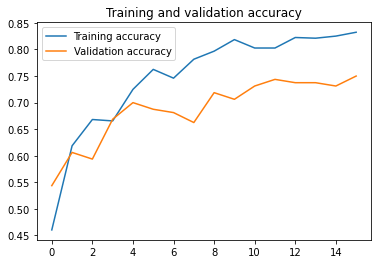

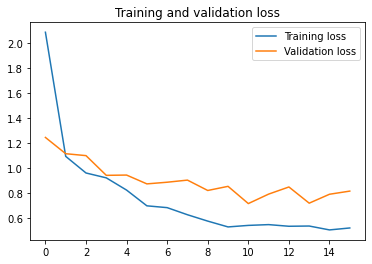

In [24]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc)) # Get number of epochs

plt.figure()
#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  ( epochs,     loss, label='Training loss' )
plt.plot  ( epochs, val_loss, label='Validation loss' )
plt.title ('Training and validation loss')
plt.legend(loc=0)

plt.show()

In [25]:
model.save_weights('model_vgg19.h5')